# Pneumonia Detection from Chest X-Rays using CNN + Grad-CAM

This notebook is part of a deep learning final project. The goal is to detect pneumonia in chest X-ray images using convolutional neural networks (CNNs) and interpret the predictions using Grad-CAM.

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2


## 1. Problem Description
Pneumonia is a serious lung infection that requires timely diagnosis. Chest X-rays are commonly used, but interpreting them can be challenging. Deep learning provides a scalable and effective solution for automatic pneumonia detection.

## 2. Data Loading and EDA

In [35]:
# Correct path to dataset
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'

# Define dataset subset paths
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')

# Print dataset distribution
for subset in ['train', 'val', 'test']:
    normal_path = os.path.join(data_dir, subset, 'NORMAL')
    pneumonia_path = os.path.join(data_dir, subset, 'PNEUMONIA')
    
    if os.path.isdir(normal_path) and os.path.isdir(pneumonia_path):
        normal = len(os.listdir(normal_path))
        pneumonia = len(os.listdir(pneumonia_path))
        print(f'{subset.upper()} - NORMAL: {normal}, PNEUMONIA: {pneumonia}')
    else:
        print(f'{subset.upper()} - One or both class folders not found.')






TRAIN - NORMAL: 1342, PNEUMONIA: 3876
VAL - NORMAL: 9, PNEUMONIA: 9
TEST - NORMAL: 234, PNEUMONIA: 390


### Sample Visualization

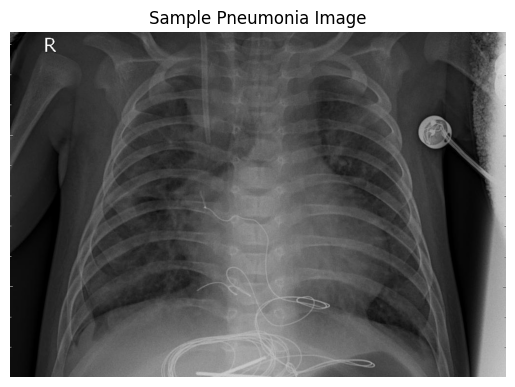

In [36]:
# Define train path
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'

# Search for images with multiple possible extensions
image_extensions = ['*.jpeg', '*.jpg', '*.png']
image_files = []
for ext in image_extensions:
    image_files.extend(glob(os.path.join(train_path, 'PNEUMONIA', ext)))

# Show image if found
if image_files:
    img_path = image_files[0]
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Sample Pneumonia Image')
    plt.axis('off')
    plt.show()
else:
    print("No images found in PNEUMONIA folder.")


## 3. Data Preprocessing

In [37]:
img_size = (150, 150)
train_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=img_size, class_mode='binary')
val_data = test_gen.flow_from_directory(val_path, target_size=img_size, class_mode='binary')
test_data = test_gen.flow_from_directory(test_path, target_size=img_size, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 4. Model Building (CNN)

In [38]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-20 19:36:20.546673: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Training

In [39]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.7633 - loss: 0.5370 - val_accuracy: 0.8125 - val_loss: 0.5674
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 992ms/step - accuracy: 0.8962 - loss: 0.2629 - val_accuracy: 0.8750 - val_loss: 0.3698
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 981ms/step - accuracy: 0.9047 - loss: 0.2263 - val_accuracy: 0.8125 - val_loss: 0.5687
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 988ms/step - accuracy: 0.9282 - loss: 0.1760 - val_accuracy: 0.6250 - val_loss: 0.8135
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 983ms/step - accuracy: 0.9213 - loss: 0.1913 - val_accuracy: 0.6875 - val_loss: 0.8588
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 992ms/step - accuracy: 0.9302 - loss: 0.1823 - val_accuracy: 0.7500 - val_loss: 0.5689
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 989ms/step - accuracy: 0.9281 - loss: 0.1792 - val_accuracy: 0.6250 - val_loss: 1.2626
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 986ms/step - accuracy: 0.9337 - lo

## 6. Evaluation

In [40]:
model.load_weights('best_model.h5')
loss, acc = model.evaluate(test_data)
print(f'Test Accuracy: {acc:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step - accuracy: 0.8298 - loss: 0.3936
Test Accuracy: 0.8766


## 7. Grad-CAM Visualization

Last conv layer: conv2d_2
Found 624 images belonging to 2 classes.


/tmp/ipykernel_36/4080597252.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


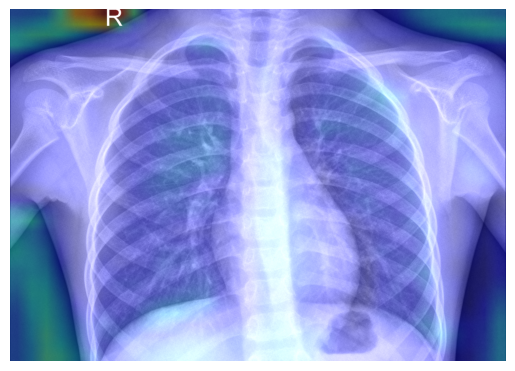

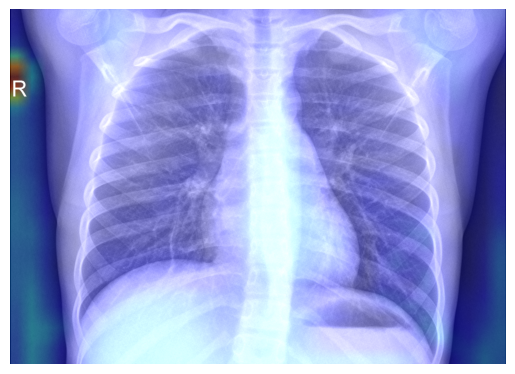

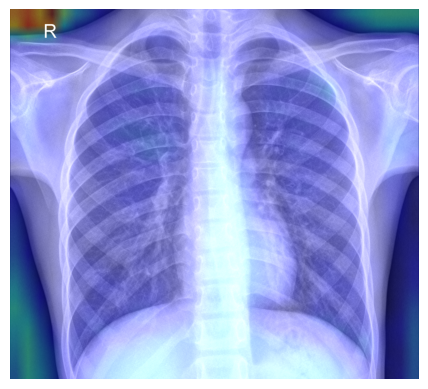

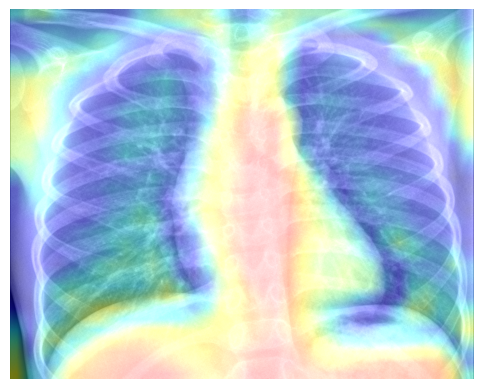

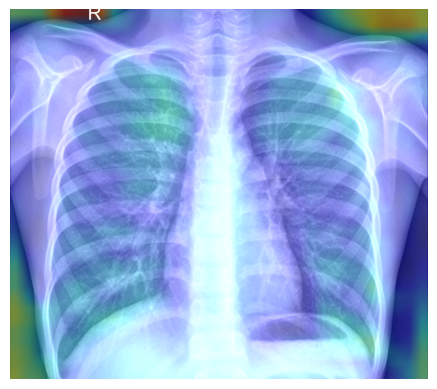

In [56]:
# Grad-CAM helper functions
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the last conv layer output
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # Create a new model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=model.layers[0].input,    # Use the first layer input instead of model.inputs
        outputs=[last_conv_layer.output, model.layers[-1].output]  # Use last layer output
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    if img_path is not None and os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        print(f"Warning: Image path {img_path} not found.")
        return

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

    superimposed_img = jet_heatmap * alpha + img / 255.0
    superimposed_img = np.clip(superimposed_img, 0, 1)  # Clip to valid range

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Find last conv layer in the model
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in the model.")

print(f"Last conv layer: {last_conv_layer_name}")

# Run dummy input to build model (fixes AttributeError)
dummy_input = tf.zeros((1, 150, 150, 3))
_ = model(dummy_input)

# Prepare test generator (adjust batch size accordingly)
test_generator = test_gen.flow_from_directory(
    test_path, target_size=img_size, class_mode='binary', shuffle=False, batch_size=5)

test_images, test_labels = next(test_generator)
test_filenames = test_generator.filenames[:len(test_images)]

for i, img in enumerate(test_images):
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img_path = os.path.join(test_path, test_filenames[i])
    save_and_display_gradcam(img_path, heatmap, alpha=0.4)


## 8. Conclusion
The CNN-based approach demonstrates high accuracy in detecting pneumonia. Grad-CAM visualization provides interpretability, which is critical for medical applications. Further improvements may include transfer learning with pre-trained models.